<a href="https://colab.research.google.com/github/queyrusi/cropseed/blob/main/crop_seed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Crop Seed Classification and Detection
 [![Version](https://img.shields.io/badge/version-1.3-brightgreen)](https://img.shields.io/badge/version-1.0-brightgreen)

## Survol de l'existant

Bose, Ranjith, Surya Prakash, Subham Kumar Singh, and Dr Vishwanath. “Intelligent Approach for Classification of Grain Crop Seeds Using Machine Learning,” 2018.

> *...we use convolutional neural network with increased parameters to achieve better results.*

> ...*it is clear that CNN has higher accuracy for all the trained images in all type of the clusters thus by implementing the neural networks we can get much better results.*


L' utilisation des CNN est légitime car elle semble bien fonctionner.

\
Vlasov, Andrey, and Alexander Fadeev. “Comparison of Object Classification Methods in Seed Stream Separation,” 2017. https://doi.org/10.2991/itsmssm-17.2017.38.

> *The most noticeable difference between traditional and deep learning is that deep learning provides more accuracy but at the same time needs to be trained on much bigger and variable image dataset.*


Nous nous affranchirons de ce problème en utilisant un CNN déjà entrainé à l'extraction de caractéristiques semblables (Transfer Learning sur ImageNet).




## Load Data
Before you go on:
1. Follow this [link to the data](https://drive.google.com/drive/folders/1qu5KBWEnz2WA2ENp7D02xJQ0AJrdGhoM?usp=sharing).
2. Right click on folder name, click "Add shortcut to Drive".
3. Add shortcut to desired path in you drive. 

Mount the drive with the following:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


💡 Make sure `root_path` leads to the directory containing the data from within your mounted drive:


In [2]:
import pathlib 

root_path = pathlib.Path('/content/drive/My Drive') 
data_dir = root_path / 'crop_seed_dataset'
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
test_classified_dir = data_dir / 'test_classified'
model_dir = root_path / 'models'

In [3]:
! apt-get install tree
! pip install tqdm -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.56.1)


## Imports

In [4]:
%matplotlib inline
import datetime as dt
import time
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import shutil
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from keras.applications import xception
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn.utils

from PIL import Image
import cv2
import imutils
from scipy import ndimage

from skimage import data
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
from skimage.filters import try_all_threshold
from skimage.color import rgb2gray

from tqdm.notebook import tqdm

In [5]:
# Activate this only if you're on darkmode.
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [6]:
start = dt.datetime.now()

## Description du paquet



Dans `/dataset`, de haut en bas :
+ `/augmented` contiendra des images augmentées pour TTA (Test Time Augmentation)
+ `/segmentation` un répertoire de travail pour l'identification de grains
+ `/test` constitué sur un pourcentage d'images de `/train`
+ `/test_classified` les images de `test` mais classifiées pour faciliter la création par `flow_from_dir()` des images pour TTA
+ `/thresholded` les images du train set seuillées par Global Otsu
+ `/train` contient l'**ensemble** des images disponibles originellement ⚠️ Ce n'est donc pas le train set, mais la somme du train set et du test set. La séparation test/train set est suivie dans les dataframes `train` et `test` dans la suite du notebook


In [7]:
! tree -C -d  /content/drive/My\ Drive/crop_seed_dataset
#             ^-- root_path here

/content/drive/My Drive/crop_seed_dataset
├── augmented
├── segmentation
├── test
├── test_classified
│   ├── barley
│   ├── corn
│   ├── wheat_hard
│   └── wheat_soft
├── thresholded
│   ├── barley
│   ├── corn
│   ├── wheat_hard
│   └── wheat_soft
└── train
    ├── barley
    ├── corn
    ├── wheat_hard
    └── wheat_soft

18 directories


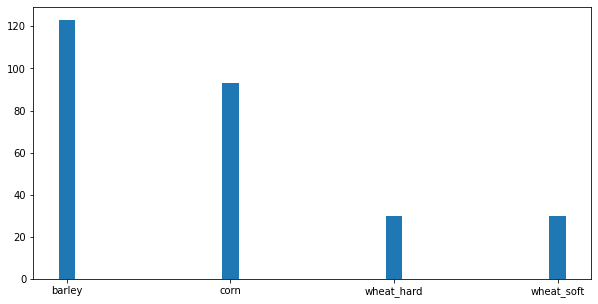

In [8]:
CATEGORIES = ['barley', 'corn', 'wheat_hard', 'wheat_soft']
LEN_CATEGORIES = len(CATEGORIES)
SEED = 42
SAMPLE_PER_CATEGORY = 10

class_distribution = [len(os.listdir(train_dir / category)) for category in CATEGORIES]

plt.figure(figsize=(10, 5))
plt.bar(CATEGORIES, class_distribution, width=0.1);

+ Représentation des classes déséquilibrée, notamment entre `wheat_soft` et `wheat_hard` qui se ressemblent (peut poser problème pour la suite).
+ Images de bonne qualité, mais les grains se chevauchent et beaucoup sont coupés sur les bords de la photo
+ Le flash engendre un effet "vignette"
+ On ne voit pas toujours le fond du plat (problème pour l'identification/segmentation)
+ Images classiques, justifie l'emploi d'un classificateur entraîné sur ImageNet

## Transfer Learning avec Xception

In [9]:
def read_img(filepath, size=None):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img

In [10]:
def plot_conf_matrix(y_gt, y_pred):
    cnf_matrix = confusion_matrix(y_gt, y_pred)
    fig, ax = plt.subplots(1)
    fig.set_size_inches(9.5, 3.5)
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Blues, annot=True)
    ax.set_xticklabels(CATEGORIES)
    ax.set_yticklabels(CATEGORIES, rotation='horizontal')
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('Confusion matrix.png', dpi=300)
    plt.show();

### Séparations des sets

+ Training Set

On prend un pourcentage de chacune des classes pour le constituer :

In [11]:
train_ratio = 0.7 #@param {type:"slider", min:0.1, max:0.99, step:0.1}
train = []

for category_id, category in enumerate(CATEGORIES):
    category_sample_names = os.listdir(os.path.join(
        train_dir, category))
    train_size = int(len(category_sample_names) * train_ratio)
    i = 0
    for filename in os.listdir(os.path.join(train_dir, category)):
        if i < train_size and\
         filename.split('.')[-1] in ['jpg', 'png']:
            train.append(['train/{}/{}'
            .format(category, filename), 
                          category_id, category])
            i += 1
train = pd.DataFrame(train, columns=['filepath', 'category_id', 
                                     'category'])
train.head(2)
train.shape

(193, 3)

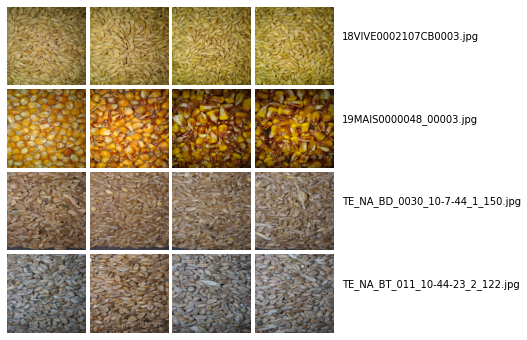

In [12]:
fig = plt.figure(1, figsize=(LEN_CATEGORIES * 1.5, LEN_CATEGORIES * 1.5))
grid = ImageGrid(fig, 111, nrows_ncols=(LEN_CATEGORIES, LEN_CATEGORIES), axes_pad=0.05)
INPUT_SIZE = 299  # working on square image to fit keras xception doc
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['filepath'].values[:LEN_CATEGORIES]:
        ax = grid[i] 
        img = read_img(data_dir / filepath, (INPUT_SIZE, INPUT_SIZE))
        _ = ax.imshow(img / 255.)
        _ = ax.axis('off')
        if i % LEN_CATEGORIES == LEN_CATEGORIES - 1:
            _ = ax.text(330, 112, filepath.split('/')[2], verticalalignment='center')
        i += 1
plt.show()

+  Séparation validation/train (facultative mais bonne pratique)

In [13]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(153, 40)

+ Test set


Le test set est juste l'ensemble des images restantes (le test est donc représentatif du dataset originel)

In [14]:
test_ratio = 1 - train_ratio
test = []

constitute_test, constitute_test_classified = True, True

if 'test' not in os.listdir(data_dir):
    os.makedirs(data_dir + '/test')
    constitute_test = True
else:
    constitute_test = False
if 'test_classified' not in os.listdir(data_dir):
    constitute_test_classified = True
    os.makedirs(test_classified_dir)
    for cat in CATEGORIES:
        os.makedirs(os.path.join(test_classified_dir, cat))
else:
    constitute_test_classified = False

for category_id, category in enumerate(CATEGORIES):
    category_sample_names = os.listdir(os.path.join(
    train_dir, category))
    category_sample_names.reverse()  # training samples start from bottom
    test_size = len(os.listdir(os.path.join(train_dir, category))) - len(
        train[train['category'] == category])
    i, j = 0, 0
    for filename in tqdm(category_sample_names):
        if i < test_size:            
            if constitute_test:
                _ = shutil.copy(os.path.join(train_dir, category, filename), 
                                test_dir)
            if constitute_test_classified:
                _ = shutil.copy(os.path.join(train_dir, category, filename),
                                os.path.join(test_classified_dir, category))
            test.append(['test/{}'.format(filename), category_id, category])
            i += 1
        j += 1
test = pd.DataFrame(test, columns=['filepath', 'category_id_gt', 'category_gt'])
test.head(4)
test.shape
constitute_test = False
constitute_test_classified = False

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

### Entraînement

+ Extraction de features avec Xception 

In [15]:
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
i = 0
for file in tqdm(train['filepath']):
    img = read_img(data_dir / file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
    i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

  0%|          | 0/193 [00:00<?, ?it/s]

Train Images shape: (193, 299, 299, 3) size: 51,763,179


In [16]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=10, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=10, verbose=1)
print('Xception train features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((153, 299, 299, 3), (40, 299, 299, 3), (153,), (40,))
4/4 [==============================] - 2s 249ms/step
Xception train features shape: (153, 2048) size: 313,344
Xception valid features shape: (40, 2048) size: 81,920


+ Régression logistique sur les features extraites

In [17]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

In [18]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 1.0


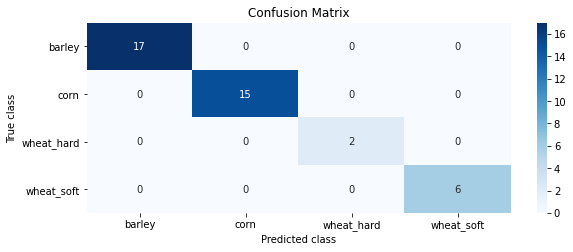

In [19]:
plot_conf_matrix(yv, valid_preds)

### Test

In [20]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
i = 0  # enumerate not working w/ tqdm 
for filepath in tqdm(test['filepath']):
    img = read_img(data_dir / filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
    i += 1
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

  0%|          | 0/83 [00:00<?, ?it/s]

test Images shape: (83, 299, 299, 3) size: 22,260,849


In [21]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=10, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

9/9 [==============================] - 2s 207ms/step
Xception test bottleneck features shape: (83, 2048) size: 169,984


In [22]:
test.insert(2, 'category_id_predicted', test_preds)
test.insert(4, 'category_predicted', [CATEGORIES[c] for c in test_preds])
test[['filepath', 'category_predicted']].to_csv('submission.csv', index=False)

In [23]:
print('Validation Xception Accuracy {}'.format(accuracy_score(test['category_id_gt'], test_preds)))

Validation Xception Accuracy 1.0


In [24]:
test.head(2)

,filepath,category_id_gt,category_id_predicted,category_gt,category_predicted
0,test/18VIVE0000654CB0002.jpg,0,0,barley,barley
1,test/18VIVE0001503CB0003.jpg,0,0,barley,barley


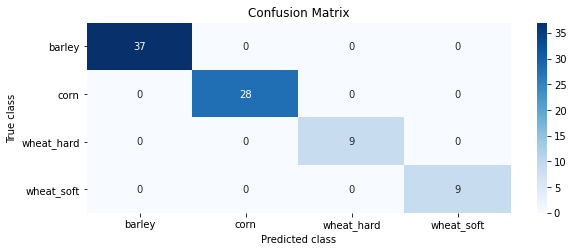

In [25]:
plot_conf_matrix(test['category_id_gt'], test_preds)

### Éprouver le CNN avec augmentation du test set (TTA)

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_gt = []
aug_test = []

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=10,
                             zoom_range=0.5,
                             horizontal_flip=True)
datagen.fit(x_test)
print("datagen fitted.")

gen = datagen.flow_from_directory(
    directory=test_classified_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    color_mode="rgb",
    batch_size=len(test),
    class_mode="categorical",
    shuffle=False,
    seed=42
)

for x_batch, y_batch in gen:
    x_test_aug  = x_batch
    y_gt = [np.where(y_batch[i] == 1.)[0][0] for i in range(y_batch.shape[0])]
    break  # we generate just one batch, enough to do a small test

augmented_ordered = os.listdir(os.path.join(data_dir, 'augmented'))
augmented_ordered.sort(key = lambda x: x.split('_')[0])
batch1 = [['augmented/' + augmented_ordered[i], CATEGORIES[y_gt[i]], y_gt[i]] for i in tqdm(range(len(x_test)))]
batch1 = pd.DataFrame(batch1, columns=['datapath', 'category_gt', 'category_id_gt'])

datagen fitted.
Found 83 images belonging to 4 classes.


  0%|          | 0/83 [00:00<?, ?it/s]

In [27]:
batch1 = sklearn.utils.shuffle(batch1)
batch1 = batch1.reset_index(drop=True)

In [28]:
batch1.head(4)

,datapath,category_gt,category_id_gt
0,augmented/_31_9922192.png,barley,0
1,augmented/_79_2114792.png,wheat_soft,3
2,augmented/_47_6939705.png,corn,1
3,augmented/_23_9106824.png,barley,0


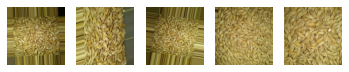

In [29]:
f, ax = plt.subplots(1,5)
for i, filepath in enumerate(os.listdir(data_dir / 'augmented')):
    if i < 5:
        img = read_img(data_dir / 'augmented' / filepath)
        _ = ax[i].imshow(img / 255.)        
        _ = ax[i].axis('off')

In [30]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
i = 0  # enumerate not working w/ tqdm 

for filepath in tqdm(str(data_dir) + '/' + batch1['datapath']):
    #                ^-- creates a series with all paths
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
    i += 1
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

  0%|          | 0/83 [00:00<?, ?it/s]

test Images shape: (83, 299, 299, 3) size: 22,260,849


In [31]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=10, verbose=1)
print('Xception test features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

9/9 [==============================] - 2s 200ms/step
Xception test features shape: (83, 2048) size: 169,984


In [32]:
print('Augmented Dataset Xception Accuracy {}'.format(accuracy_score(batch1['category_id_gt'], test_preds)))

Augmented Dataset Xception Accuracy 0.891566265060241


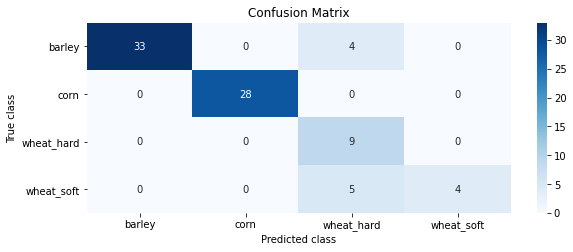

In [33]:
plot_conf_matrix(batch1['category_id_gt'], test_preds)

on a quelques mauvaises classifications ; regardons des éléments litigieux :

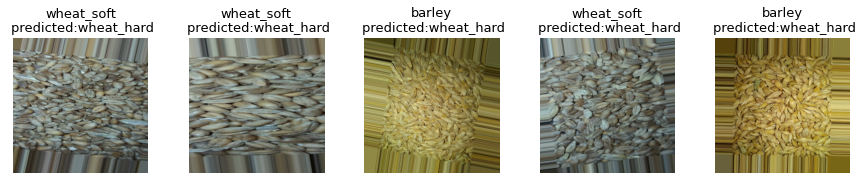

In [34]:
f, ax = plt.subplots(1,5)
f.subplots_adjust(wspace=0.3)
f.set_figheight(15)
f.set_figwidth(15)
j = 0
for i, filepath in enumerate(batch1['datapath']):
    if j < 5 and  batch1['category_id_gt'][i] != test_preds[i]:
        img = read_img(data_dir /  filepath, (INPUT_SIZE, INPUT_SIZE))        
        _ = ax[j].imshow(img / 255.)   
        _ = ax[j].set_title(batch1['category_gt'][i] + '\n predicted:' + CATEGORIES[test_preds[i]], fontsize=13)
        _ = ax[j].axis('off')
        j += 1

Ce sont des images très fortement modifiées (improbable IRL), et dans des classes assez similaires visuellement ; le classificateur est excusé

### Expérience sur image seuillée

+  Choix du seuillage

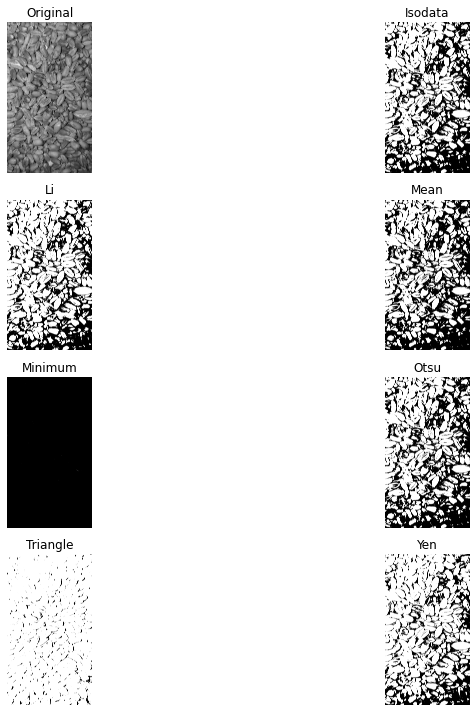

In [35]:
img = rgb2gray(np.array(image.load_img(os.path.join(test_dir, os.listdir(test_dir)[-4]))))
fig, ax = try_all_threshold(img, figsize=(15, 10), verbose=False)
plt.show()

L'algorithme type Otsu donne une bonne image ;

In [36]:
for filepath in test['filepath']:
    im = read_img(data_dir / filepath)
    im = rgb2gray(im)
    break

# We need uint8 type here
im = np.array(im, dtype=np.uint8)

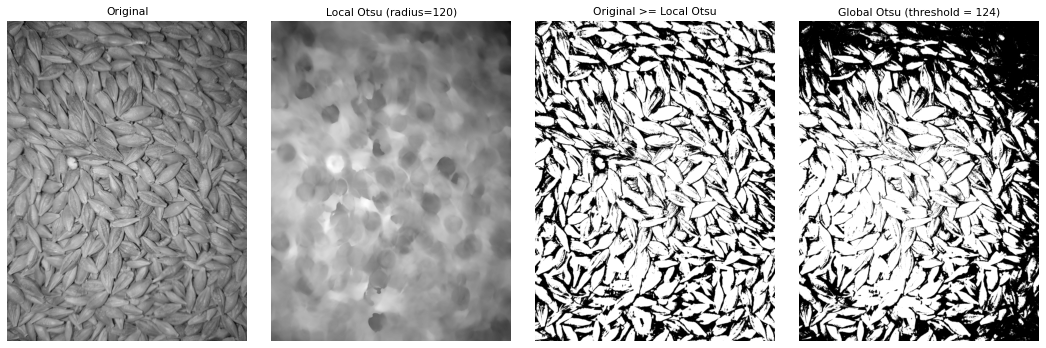

Local Otsu took 44.55163764953613 while Global only took 0.09110736846923828


In [37]:
matplotlib.rcParams['font.size'] = 9

radius = 120
selem = disk(radius)

for filepath in test['filepath']:
    im = read_img(data_dir / filepath)
    im = rgb2gray(im)
    im = np.array(im, dtype=np.uint8)
    global_otsu_tick = time.time()
    threshold_global_otsu = threshold_otsu(im)
    global_otsu_tock = time.time()
    global_otsu = im >= threshold_global_otsu
    local_otsu_tick = time.time()
    local_otsu = rank.otsu(im, selem)
    local_otsu_tock = time.time()
    fig, ax = plt.subplots(1, 4, figsize=(15, 10), sharex=True, sharey=True)
    fig.tight_layout()
    ax0, ax1, ax2, ax3 = ax.ravel()
    _ = ax0.imshow(im, cmap=plt.cm.gray)           
    _ = ax0.set_title('Original')
    _ = ax0.axis('off')
    _ = ax1.imshow(local_otsu, cmap=plt.cm.gray)
    _ = ax1.set_title('Local Otsu (radius=%d)' % radius)
    _ = ax1.axis('off')
    _ = ax2.imshow(im >= local_otsu, cmap=plt.cm.gray)
    _ = ax2.set_title('Original >= Local Otsu' % threshold_global_otsu)
    _ = ax2.axis('off')
    _ = ax3.imshow(global_otsu, cmap=plt.cm.gray)
    _ = ax3.set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
    _ = ax3.axis('off')
    plt.show()
    break
print("Local Otsu took {} while Global only took {}".format(local_otsu_tock-local_otsu_tick,
                                                            global_otsu_tock-global_otsu_tick))

In [38]:
print("Local Otsu took {}s while Global only took {}s".format(local_otsu_tock-local_otsu_tick,
                                                            global_otsu_tock-global_otsu_tick))

Local Otsu took 44.55163764953613s while Global only took 0.09110736846923828s


Local Otsu donne de meilleurs résultat (minimisation de l'effet "vignette") mais prend du temps au traitement. On choisit Global Otsu pour seuiller le train set ;

+ Seuillage des images

In [39]:
if 'thresholded' not in os.listdir(data_dir):
    os.makedirs(data_dir / 'thresholded')
    constitute = True
    for cat in CATEGORIES:
        os.makedirs(data_dir / 'thresholded' / cat)
    matplotlib.rcParams['font.size'] = 9
    radius = 120
    selem = disk(radius)
    for filepath in tqdm(train['filepath']):
        im = read_img(data_dir + filepath)
        im = np.array(rgb2gray(im), dtype=np.uint8)
        threshold_global_otsu = threshold_otsu(im)
        global_otsu = im >= threshold_global_otsu
        global_otsu = Image.fromarray(global_otsu)
        global_otsu.save(data_dir / 'thresholded' / filepath.split('/')[-2] / 'thresh_' + filepath.split('/')[-1], 'JPEG')

+  Extraction des features des binaires

In [40]:
x_thresh_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
i = 0
for file in tqdm(train['filepath']):
    img = read_img(str(data_dir) + '/thresholded/' + file.split('/')[-2] + '/thresh_' + file.split('/')[-1], (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_thresh_train[i] = x
    i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

  0%|          | 0/193 [00:00<?, ?it/s]

Train Images shape: (193, 299, 299, 3) size: 51,763,179


In [41]:
X_thresh_tr = x_thresh_train[train_idx]
print(X_thresh_tr.shape)
train_x_thresh_bf = xception_bottleneck.predict(X_thresh_tr, batch_size=10, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_thresh_bf.shape, train_x_thresh_bf.size))

(153, 299, 299, 3)
16/16 [==============================] - 3s 203ms/step
Xception train bottleneck features shape: (153, 2048) size: 313,344


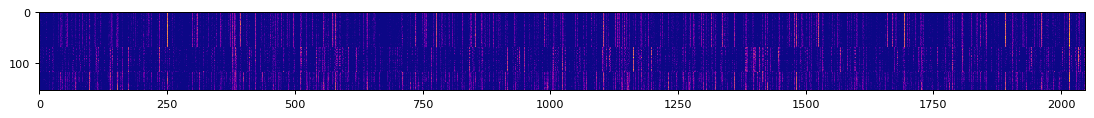

In [42]:
plt.figure(figsize=(15, 5), dpi=90)
_ = plt.imshow(train_x_bf, cmap='plasma', interpolation='nearest',)

Les vecteurs-feature extraits par Xception paraissent simples à clusteriser, même à l'œil nu. Bien que ce sentiment vienne en partie du fait que le plot est fait dans l'ordre des classes ligne par ligne, on voit tout de même que les quatres bandes sont moins distinctes dans x_threshold :

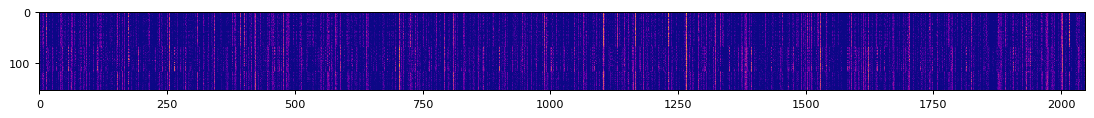

In [43]:
plt.figure(figsize=(15, 5), dpi=90)
_ = plt.imshow(train_x_thresh_bf, cmap='plasma', interpolation='nearest', )

Certaines zones denses en activation ont disparu, d'autres sont apparues. L'explicabilité de l'extraction réalisée par les Convnets épais est très complexe, je ne pousse pas l'interprétation plus loin.

+ Couches activée intermédiaires 

In [44]:
def show_n_layers(layer_name, n_features=22):
    base_model = xception_bottleneck 
    model = Model(inputs=xception_bottleneck.input, 
                  outputs=base_model.get_layer(layer_name).output)
    file = train['filepath'][0]
    imag = read_img(os.path.join(str(data_dir),'thresholded',
                                 file.split('/')[-2] + '/thresh_' + file.split('/')[-1]))
    x = image.img_to_array(imag)
    x = np.expand_dims(x, axis=0)
    x = xception.preprocess_input(x)
    activations = model.predict(x)
    fig = plt.figure(1, figsize=(16, 4))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 11), axes_pad=0.05)
    i = 0
    for i in range(min(activations.shape[-1], n_features)):
        ax = grid[i] 
        img = read_img(data_dir / filepath)
        _ = ax.imshow(activations[0, :, :, i], cmap='viridis')
        if i == 11:
            ax.set_ylabel( layer_name + ', ' + str(min(activations.shape[-1], n_features)) + '/' 
                    + str(activations.shape[-1]) + ' channels',y=0.45, horizontalalignment='left', labelpad=15, fontsize=9.5)
    plt.show()

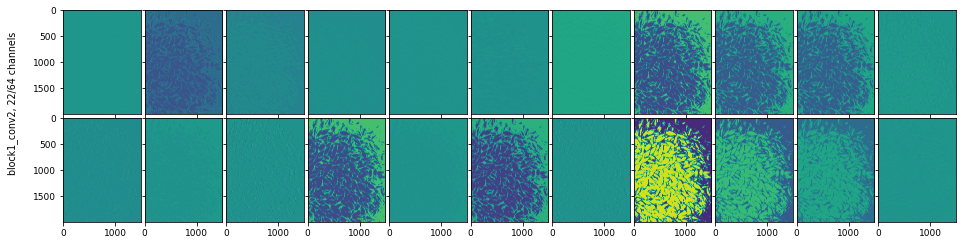

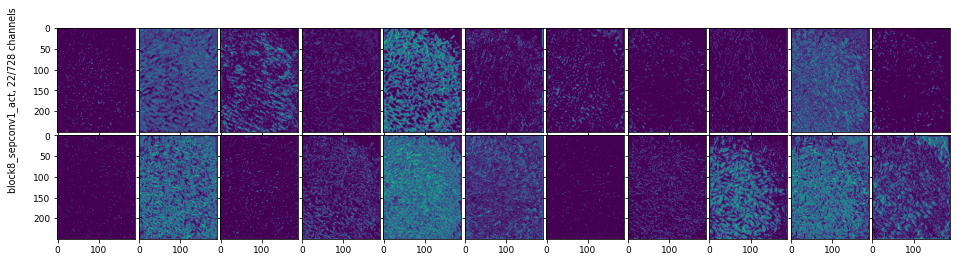

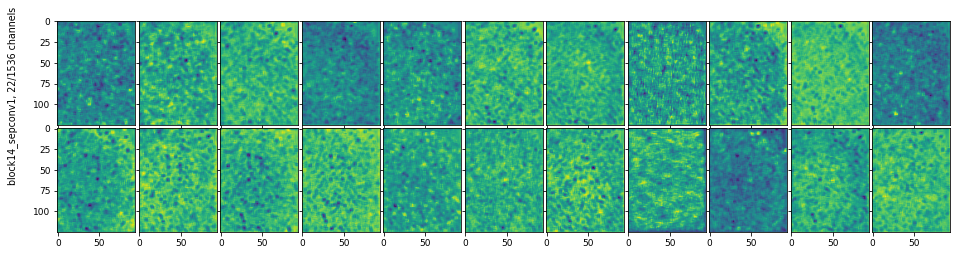

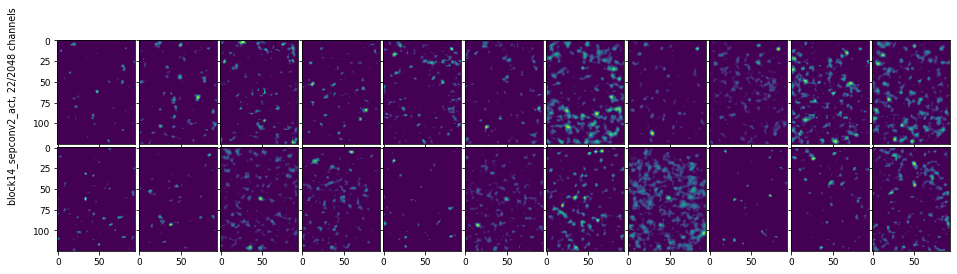

In [45]:
show_n_layers('block1_conv2')
show_n_layers('block8_sepconv1_act')
show_n_layers('block14_sepconv1')
show_n_layers('block14_sepconv2_act')

+ Les première couches de l'extracteur retiennent l'allure générale de la photo ; les activations gardent quasiment toute l'information de l'original
+ Au fil des couches, les activations deviennent plus abstraites et difficiles à interpréter visuellement (elles encodent des concepts haut-niveau - bords, géométries verticales/horizontales, textures, angles...)
+ Dans les dernières couches, la structure est si complexe/irrégulière qu'aucun motif nouveau ne semble être appris par le réseau (peu d'activations) 



---





## Variétés d'une espèce

Fixons une espèce (maïs par exemple). 
Nous avons un dataset d'images étiquettée de $l_{1}$ à $l_{n}$ , (les $l_{i}$ sont les variétés), avec $n$ variant selon le contexte ( [1000 variétés](https://fr.wikipedia.org/wiki/Variétés_françaises_de_maïs) en France ?)

+ Problème des mélanges : l'image du mélange de deux classes peut présenter des caractéristiques similaires à l'image d'une seule classe. Par exemple $rouge + corné \approx coloré$ si on prend en compte le fait que les grains peuvent être un peu vieux ou juste particuliers suivant la récolte, d'autant que des grains recouverts par d'autres sont dans l'ombre et donc changent de couleur.



![](https://markdown.data-ensta.fr/uploads/upload_a3531c3cfe42e46383024009788c0d23.png)

### Détection de grains avec watershed

à partir d'une image légèrement ajustée à la main (avec "Photos" pour MacOS pour enlever l'effet "vignette", essentiellement) pour faciliter le seuillage

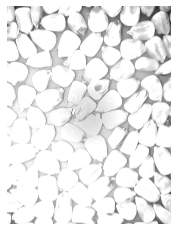

In [46]:
_ = plt.imshow(read_img(data_dir / 'segmentation/modified_19MAIS0000009_00003.jpeg')/255.)
_ = plt.axis('off')

In [47]:
if 'segmentation' not in os.listdir(data_dir):
    os.makedirs(data_dir / 'segmentation')

+ Seuilage avec Local Otsu

In [48]:
image1 = read_img(data_dir / 'segmentation/19MAIS0000009_00003.jpg')
img = cv2.imread(os.path.join(str(data_dir),
                              'segmentation',
                              'modified_19MAIS0000009_00003.jpeg'))
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
local_otsu =  rank.otsu(gray, selem)
thresh = gray >= local_otsu

+ Algorithme watershed

In [49]:
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=150, labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)

In [50]:
thresh = np.uint8(thresh)
imag = read_img(data_dir / 'segmentation/19MAIS0000009_00003.jpg')
for label in np.unique(labels):
    if label == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = cnts[0]
    rect = cv2.minAreaRect(cnts)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    _ = cv2.drawContours(imag,[box],-1,(0,255,0), thickness=7)

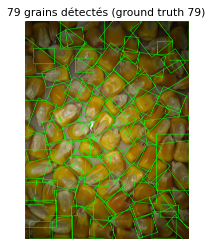

In [51]:
_ = plt.imshow(imag/255)
_ = plt.axis('off')
_ = plt.title('{} grains détectés (ground truth 79)'.format(len(np.unique(labels))))

In [52]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Total time 289 s.
